# Recommendation

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn import cross_validation
from sklearn import cross_validation as cv
from sklearn.metrics import mean_squared_error
from math import sqrt

import scipy.sparse as sp
from scipy.sparse.linalg import svds

# Recharge de données MovieLens

In [7]:
def loadMovieLens(path='data/movielens'):
    # Get movie titles
    movies={}
    for line in open(path+'/u.item', encoding = "ISO-8859-1"):
        (id,title)=line.split('|')[0:2]
        movies[id]=title
    
    # Load data
    prefs={}
    for line in open(path+'/u.data'):
        (user,movieid,rating,ts)=line.split('\t')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
    return prefs

#perfs = loadMovieLens()
#print (perfs)
## {user_id :{'item_name': rating, 'item_name': rating}, user_id:{.....} }

#La fonction Root Mean Squared Error
def rmse(prediction, X):
    prediction = prediction[X.nonzero()].flatten() 
    X = X[X.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, X))


path='data/movielens'
info = open(path+'/u.info')
n_users = info.readline().split(' ')[0]
n_items = info.readline().split(' ')[0]
n_ratings = info.readline().split(' ')[0]
#n_users = 943
#n_items = 1682
nbr_users = int(n_users)
nbr_items = int(n_items)
#Construction du tableau de rang
Ratings = np.zeros((nbr_users,nbr_items))
#le format de <<u.data>> user id | item id | rating | timestamp  
for line in open(path+'/u.data'):
    (idUser, idItem, rating, ts) = line.split('\t')
    Ratings[int(idUser)-1][int(idItem)-1]=rating
print ("Le tableau de rang : ")
print (Ratings)

Le tableau de rang : 
[[ 5.  3.  4. ...,  0.  0.  0.]
 [ 4.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 5.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  5.  0. ...,  0.  0.  0.]]


# Filtrage Collaborative

# Version SVD

In [8]:
#Calcule le en 
listsNbrSingular = []
for i in range(1,100):
    u, s, vt = svds(Ratings, k = i)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    listsNbrSingular.append(rmse(X_pred, Ratings))

print ("Le tableau de rang prédit en utilisant SVD : ")
print (X_pred)

Le tableau de rang prédit en utilisant SVD : 
[[  5.15012418e+00   3.32596365e+00   2.27546531e+00 ...,   1.12141930e-02
    4.68706196e-02   1.66252615e-01]
 [  2.51764483e+00  -1.78511514e-01   3.62505477e-01 ...,   6.73320692e-03
    2.31610984e-02  -1.61138977e-02]
 [ -1.36174623e-01  -1.81604302e-01  -3.80998920e-01 ...,   3.58328220e-02
   -3.03948135e-03  -2.21448805e-02]
 ..., 
 [  3.82177376e+00  -7.39747114e-02   5.09624261e-01 ...,  -4.43019730e-03
    1.03651790e-03   6.69348223e-04]
 [  5.65701243e-01   1.85356603e-01   2.42039901e-01 ...,  -3.68256003e-03
    2.51845386e-02  -8.85770664e-04]
 [  8.51223552e-01   3.37549384e+00   2.37912208e+00 ...,  -3.20881529e-03
    3.80934440e-02   3.24869610e-02]]


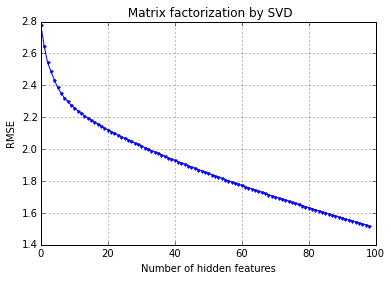

In [9]:
plt.plot(range(len(listsNbrSingular)), listsNbrSingular, marker='.')
plt.title(' Matrix factorization by SVD')
plt.xlabel('Number of hidden features')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

# Version Modèle Classique L2

In [10]:
plt.close()
K = 5
P, s, Q = svds(Ratings, K)

In [11]:
ErreursClassique = []
def modele_classique_L2(R, P, Q, K, steps=100, alpha=0.005, lamda=0.02):
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    #descente de gradient stochastique
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * ( eij * Q[k][j] - lamda * P[i][k] ) 
                        Q[k][j] = Q[k][j] + alpha * ( eij * P[i][k] - lamda * Q[k][j] )
        eR = np.dot(P,Q)
        e = rmse(eR, R)
        ErreursClassique.append(e)
    return P, Q, eR

nP, nQ, nR= modele_classique_L2(Ratings, P, Q, K)
print ("Le tableau de rang prédit en utilisant le Modèle Classique L2 : ")
print (nR)

Le tableau de rang prédit en utilisant le Modèle Classique L2 : 
[[ 4.07449428  3.22448487  2.86868543 ...,  1.20239981  2.52344596
   2.64298097]
 [ 4.31238037  3.31769426  2.19600737 ...,  1.05469551  2.68888383
   2.55472346]
 [ 3.06611589  2.69351441  2.88167436 ...,  1.03372753  1.76368669
   1.95738416]
 ..., 
 [ 4.31327521  3.54733776  3.05136846 ...,  1.46747472  2.47850258
   2.6591285 ]
 [ 4.51039904  3.73676126  2.18218786 ...,  1.00995467  2.61456407
   2.13707011]
 [ 3.77470761  3.4848214   3.96678344 ...,  1.54434252  1.97984835
   2.19947412]]


# Version Modèle avec biais utilisateur et items

[[ 3.70682479  3.05975667  2.94266228 ...,  1.45215007  2.72400796
   2.87189217]
 [ 3.83521208  3.29372122  2.86491436 ...,  1.62991067  2.77581532
   2.72268816]
 [ 3.28945118  2.70883956  2.44378589 ...,  1.01372624  2.31606067
   2.35784784]
 ..., 
 [ 4.19828939  3.5767617   3.23292559 ...,  1.82157176  3.01696038
   3.12156598]
 [ 4.37801097  3.95007803  3.02780321 ...,  2.18121278  2.69748885
   2.66161276]
 [ 3.78051424  3.12045549  3.52257809 ...,  1.82165819  2.06953843
   2.67919719]]


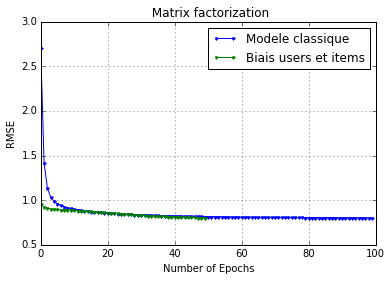

In [12]:
ErreursBiais = []
def modele_biais_users_items(R, P, Q, K, steps=50, alpha=0.005, lamda=0.02):
    miu = R.sum()/float(n_ratings)
    eR = np.zeros((nbr_users,nbr_items))
    bu=[]
    for i in range(nbr_users):
        bu.append(R[i].sum()/(len(R[i].nonzero()[0])*1.0) - miu)
    bit=[]
    for j in range(nbr_items):
        bit.append(R[:,j].sum()/(len(R[:,j].nonzero()[0])*1.0) - miu)
    for step in range(steps):
        for i in range(len(R)):
            bi = bu[i]
            for j in range(len(R[i])):
                bj = bit[j]
                if R[i][j] > 0:
                    #descente de gradient stochastique
                    eij = R[i][j] - (miu + bi + bj + np.dot(P[i,:],Q[:,j]))
                    bi = bi + alpha * (eij - lamda * bi)
                    bj = bj + alpha * (eij - lamda * bj)
                    miu = miu + alpha * (eij - lamda * miu)
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * ( eij * Q[k][j] - lamda * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * ( eij * P[i][k] - lamda * Q[k][j])
                eR[i][j] = miu + bi + bj + np.dot(P[i,:],Q[:,j]) 
        e = rmse(eR, R)
        ErreursBiais.append(e)
    return P, Q, eR

P = np.random.rand(nbr_users,K)
Q = np.random.rand(K,nbr_items)
nP, nQ, nR= modele_biais_users_items(Ratings, P, Q, K)
print (nR)

plt.plot(range(len(ErreursClassique)), ErreursClassique, marker='.', label='Modele classique')
plt.plot(range(len(ErreursBiais)), ErreursBiais, marker='.', label='Biais users et items')
plt.title(' Matrix factorization')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()
